/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
100%|██████████| 49/49 [00:00<00:00, 4561.86it/s]


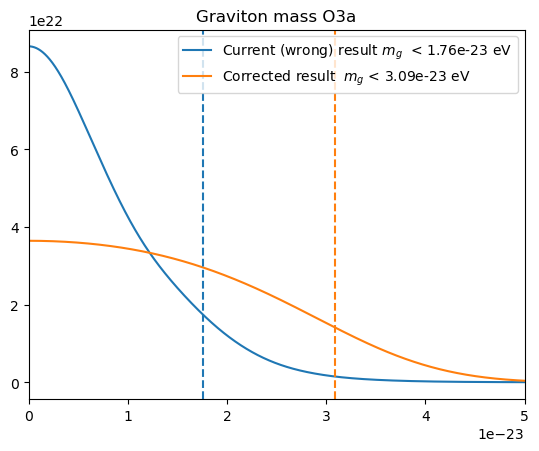

Updated graviton mass: 3.0888358432463963e-23 eV


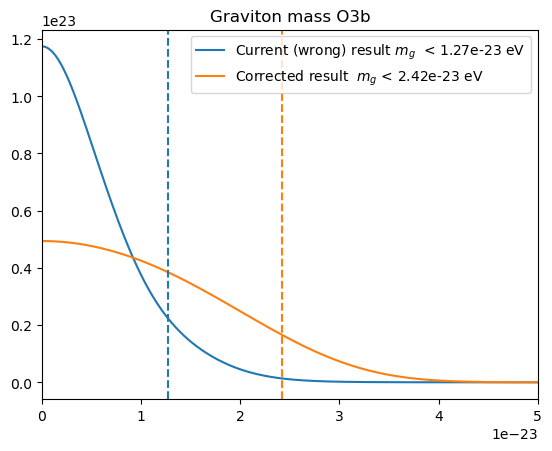

Updated graviton mass: 2.4188363586420792e-23 eV


In [1]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
events = pd.read_csv('gwtc3_events.csv')

resolution = 10000

excluded = ['GW200219_094415', 'GW200225_060421'] #problematic gwtc3 events - not excluded in final results
excluded = []
output_folder = 'c/home/tomasz.baka/mdr_A_plots/results'
gwtc3_folder = '/home/tomasz.baka/mdr_A_plots/gwtc3_data'
webroot = '/home/tomasz.baka/public_html/mdr_plots'

# Fet the paths to old result files

old_results_o3a = []
old_results_o3b = []
for i in tqdm(range(len(events))):
    event = events['asimov name'][i]
    if event not in excluded:
        
        gwtc3_name = events['gwtc3 name'][i]
        old_posterior_file = f'pdf_plots/{event}/mg_old_pdf.dat'
        result_old = glob.glob(old_posterior_file)
        if len(result_old) != 0:
            result_old = result_old[0]
            old_results_o3b.append(result_old)
            if events['catalogue'][i] == 'gwtc-2-1':
                old_results_o3a.append(result_old)

def combine_and_plot_results(results, title):
    
    graviton_mass_dataset = []
    # Get the x axis limits for plotting
    x_min = -np.inf
    x_max = +np.inf
    for i in range(len(results)):
        #convert result in peV to eV (artifact of earlier calculations)
        scale_factor = 10**(12)
        old_data = np.loadtxt(results[i])
        old_data[0]/=scale_factor
        old_data[1]*=np.abs(scale_factor)
        if old_data[0][0] > x_min:
            x_min = old_data[0][0]
        if old_data[0][-1] < x_max:
            x_max = old_data[0][-1]
        graviton_mass_dataset.append(old_data)


    # grid of points for plotting
    x = np.linspace(x_min, x_max, resolution)
    y_gwtc = np.ones(resolution)
    y_fixed = np.ones(resolution)

    for i in range(len(graviton_mass_dataset)):
        #get the official o3b results (not neede, just for comparison)
        pdf_gwtc = interp1d(graviton_mass_dataset[i][0], graviton_mass_dataset[i][1],
                            fill_value=0., bounds_error=False)
        pdf_gwtc = pdf_gwtc(x)
        y_gwtc*=pdf_gwtc #multiply probabilities

        # get the name of the event
        event = results[i].split('/')[-2]
        gwtc3_name = events.loc[events['asimov name'] == event]['gwtc3 name'].values[0] 

        #Get the A_0 posterior
        filename = f'{gwtc3_folder}/{gwtc3_name}/liv_{gwtc3_name}_alpha0_pdf.dat.gz'
        alpha_old = np.loadtxt(filename)

        mask = alpha_old[0]>=0 # for graviton mass, just interested in positive values
        pdf_fixed = interp1d(alpha_old[0], alpha_old[1], fill_value=0., bounds_error=False)
        pdf_fixed = pdf_fixed(x**2) # we have to square graviton mass to convert to A
        y_fixed *= pdf_fixed

        # renormalize probabilities
        y_fixed /=(np.sum(y_fixed)*np.abs(x_max-x_min)/resolution)
        y_gwtc /=(np.sum(y_gwtc)*np.abs(x_max-x_min)/resolution)

    # get 90% confidence intervals
    cum_prob = np.cumsum(y_gwtc)*np.abs(x_max-x_min)/resolution
    gwtc_ci = x[np.searchsorted(cum_prob, 0.9)]

    cum_prob = np.cumsum(y_fixed)*np.abs(x_max-x_min)/resolution
    fixed_ci = x[np.searchsorted(cum_prob, 0.9)]

    # plot graphs
    plt.plot(x, y_gwtc, label = f'Current (wrong) result $m_g$  < {gwtc_ci:.2e} eV')
    plt.plot(x, y_fixed, label = f'Corrected result  $m_g$ < {fixed_ci:.2e} eV')

    #plot CI with matching colors
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for j, value in enumerate([gwtc_ci, fixed_ci]):
        plt.axvline(value, linestyle = '--', color=colors[j])
    # manual limits
    plt.xlim([0, 5e-23])

    plt.title(title)
    plt.legend()
    plt.show()
    plt.close()
    print(f"Updated graviton mass: {fixed_ci} eV")
    
combine_and_plot_results(old_results_o3a, 'Graviton mass O3a')
combine_and_plot_results(old_results_o3b, 'Graviton mass O3b')

In [17]:
y_fixed

array([-4.93910908e+22, -4.93910871e+22, -4.93910759e+22, ...,
       -3.84097393e+09, -3.80916598e+09, -3.77761009e+09])